<a href="https://colab.research.google.com/github/achaudhury7378/IE-643-Implementation/blob/main/Project_Implementation_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing The Libraries

In [ ]:
import argparse
import copy
import os
import sys
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import seaborn as sns
import torch.nn.init as init
import pickle


In [ ]:
#ANCHOR Print table of zeros and non-zeros count
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')
    return (round((nonzero/total)*100,1))

def original_initialization(mask_temp, initial_state_dict):
    global model
    
    step = 0
    for name, param in model.named_parameters(): 
        if "weight" in name: 
            weight_dev = param.device
            param.data = torch.from_numpy(mask_temp[step] * initial_state_dict[name].cpu().numpy()).to(weight_dev)
            step = step + 1
        if "bias" in name:
            param.data = initial_state_dict[name]
    step = 0

        


#ANCHOR Checks of the directory exist and if not, creates a new directory
def checkdir(directory):
            if not os.path.exists(directory):
                os.makedirs(directory)

#FIXME 
def plot_train_test_stats(stats,
                          epoch_num,
                          key1='train',
                          key2='test',
                          key1_label=None,
                          key2_label=None,
                          xlabel=None,
                          ylabel=None,
                          title=None,
                          yscale=None,
                          ylim_bottom=None,
                          ylim_top=None,
                          savefig=None,
                          sns_style='darkgrid'
                          ):

    assert len(stats[key1]) == epoch_num, "len(stats['{}'])({}) != epoch_num({})".format(key1, len(stats[key1]), epoch_num)
    assert len(stats[key2]) == epoch_num, "len(stats['{}'])({}) != epoch_num({})".format(key2, len(stats[key2]), epoch_num)

    plt.clf()
    sns.set_style(sns_style)
    x_ticks = np.arange(epoch_num)

    plt.plot(x_ticks, stats[key1], label=key1_label)
    plt.plot(x_ticks, stats[key2], label=key2_label)

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    if title is not None:
        plt.title(title)

    if yscale is not None:
        plt.yscale(yscale)

    if ylim_bottom is not None:
        plt.ylim(bottom=ylim_bottom)
    if ylim_top is not None:
        plt.ylim(top=ylim_top)

    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fancybox=True)

    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight')
    else:
        plt.show()

# Defining FC1 architecture with 5 neurons in last layer

In [ ]:
class fc1(nn.Module):

    def __init__(self, num_classes = 10):
        super(fc1, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Defining the Training and Testing Modules

In [ ]:
#######################################   
# Function for Training
#######################################
def train(model, train_loader, optimizer, criterion):
    EPS = 1e-6
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (imgs, targets) in enumerate(train_loader):
        optimizer.zero_grad()         ## Clear out the gradients from the last step (otherwise we’d just accumulate the gradients from all loss.backward() calls)
        imgs, targets = imgs.to(device), targets.to(device)
        output = model(imgs)
        train_loss = criterion(output, targets)
        train_loss.backward()         ## computes the derivative of the loss w.r.t. the parameters using backpropagation.

    ## Freezing Pruned weights by making their gradients Zero
        for name, p in model.named_parameters():
            if 'weight' in name:
                tensor = p.data.cpu().numpy()
                grad_tensor = p.grad.data.cpu().numpy()
                grad_tensor = np.where(tensor < EPS, 0, grad_tensor)
                p.grad.data = torch.from_numpy(grad_tensor).to(device)
        optimizer.step()              ##  causes the optimizer to take a step based on the gradients of the parameters
    return train_loss.item()

#######################################
# Function for Testing
#######################################
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()   ## sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]                        ## get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

# Defining the Prune_by_percentile module

In [ ]:
#######################################
# Prune by Percentile module
#######################################
def prune_by_percentile(percent, resample=False, reinit=False,**kwargs):
        global step
        global mask
        global model

        step = 0
        
        for name, param in model.named_parameters():

        ## Note: We do not prune bias term
            if 'weight' in name:
                tensor = param.data.cpu().numpy()
                alive = tensor[np.nonzero(tensor)]         ## flattened array of nonzero values
                percentile_value = np.percentile(abs(alive), percent)   ## Calculating percentile value

            ## Convert Tensors to numpy and calculate
                weight_dev = param.device
                new_mask = np.where(abs(tensor) < percentile_value, 0, mask[step])
                
            ## Apply new weight and mask
                param.data = torch.from_numpy(tensor * new_mask).to(weight_dev)
                mask[step] = new_mask
                step += 1
        step = 0

# Defining the function for Weight Initialization

In [ ]:
#######################################
# Function for Initialization
#######################################
def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)


# Main procedure: Training over classes 0-5

In [ ]:

## Main
writer = SummaryWriter()

def main(args, ITE=0):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    reinit = True if args.prune_type=="reinit" else False
    
    ##########################
    ## Data Loader
    ##########################
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
    
    ##########################################################################
    ## Subsetting the MNIST data to select only Class 0,1,2,3 and 4 labels
    ##########################################################################
    if args.dataset == "mnist":
        traindataset = datasets.MNIST('../data', train = True, download = True, transform = transform)
        testdataset = datasets.MNIST('../data', train=False, transform=transform)
    ## Extracting index for classes 0,1,2,3,4
        idx = (traindataset.targets==0) | (traindataset.targets==1) | (traindataset.targets==2) | (traindataset.targets==3) | (traindataset.targets==4)
        idx2 = (testdataset.targets==0) | (testdataset.targets==1) | (testdataset.targets==2) | (testdataset.targets==3) | (testdataset.targets==4) 
    ## Loading the train data corresponding to reqd classes
        traindataset.targets = traindataset.targets[idx]
        traindataset.data = traindataset.data[idx]
    
    ## Loading the test data corresponding to reqd classes
        testdataset.targets = testdataset.targets[idx2]
        testdataset.data = testdataset.data[idx2]


    train_loader = torch.utils.data.DataLoader(traindataset, batch_size = args.batch_size, shuffle = True, num_workers = 0, drop_last = False)
    test_loader = torch.utils.data.DataLoader(testdataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, drop_last = True)
    
    ##################################################
    # Importing Network Architecture
    ##################################################
    global model
    if args.arch_type == "fc1":
       model = fc1().to(device)
    elif args.arch_type == "lenet5":
        model = LeNet5().to(device)

    ####################################
    # Weight Initialization
    ####################################
    model.apply(weight_init)

    ###########################################
    ## Copying and Saving Initial State
    ###########################################
    initial_state_dict = copy.deepcopy(model.state_dict())
    checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
    torch.save(model, f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/initial_state_dict_{args.prune_type}.pth.tar")

    ############################
    ## Making Initial Mask
    ############################
    make_mask(model)

    ###########################
    ## Optimizer and Loss
    ###########################
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()         ## Default was F.nll_loss
    
    #######################
    ## Layer Looper
    #######################
    for name, param in model.named_parameters():
        print(name, param.size())

    #########################################################
    ## Pruning
    ## NOTE: First Pruning Iteration is of No Compression
    ##########################################################
    best_accuracy = 0                     ## Variable for storing Best accuracy observed in each prune iteration
    ITERATION = args.prune_iterations     ## No. of Prune iterations as put in argument while calling
    comp = np.zeros(ITERATION,float)      ## Array for storing % weights left after pruning in each prune iteration
    bestacc = np.zeros(ITERATION,float)   ## Array for storing Best accuracy in each prune iteration 
    step = 0
    all_loss = np.zeros(args.end_iter,float)      ## Array for storing loss in each training iteration
    all_accuracy = np.zeros(args.end_iter,float)  ## Array for storing accuracy in each training iteration


    for _ite in range(args.start_iter, ITERATION):      ## Iterating over no. of prune iterations
        if not _ite == 0:      ## So that in the very first iteration, 100% of the weights remain
            prune_by_percentile(args.prune_percent, resample = resample, reinit = reinit)
            
            if reinit:                     ## If weights are set to re-initialization
                model.apply(weight_init)   ## Weight initialized using "weight_init" fn.
                step = 0
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        weight_dev = param.device
                        param.data = torch.from_numpy(param.data.cpu().numpy() * mask[step]).to(weight_dev)   ## Applying the mask over the set of parameters
                        step = step + 1
                step = 0
            
            else:                       ## If weights are NOT set to re-initialization
                original_initialization(mask, initial_state_dict)      ## Applying mask over set of parameters set of original initialization
            
            optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-4)
        
        print("\n")
        print(f" \n--- Pruning Level [{ITE}:{_ite}/{ITERATION}]: ---")
        
        #############################################
        ## Print the table of Nonzeros in each layer
        #############################################
        comp1 = print_nonzeros(model)
        comp[_ite] = comp1
        pbar = tqdm(range(args.end_iter))

        for iter_ in pbar:     ## Iterating over training iterations in each prune iteration
            ################################
            ## Frequency for Testing
            ################################
            if iter_ % args.valid_freq == 0:
                accuracy = test(model, test_loader, criterion)

                ###################
                ## Save Weights
                ###################
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
                    torch.save(model,f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/{_ite}_model_{args.prune_type}.pth.tar") 
            
            ###################
            ## Training
            ###################
            loss = train(model, train_loader, optimizer, criterion)
            all_loss[iter_] = loss
            all_accuracy[iter_] = accuracy
            # print(f"\nTrain epoch: {iter_} | All_accuracy: {all_accuracy} |  accuracy at that epoch: {accuracy}")
            # print(f"\nTrain epoch: {iter_} | All_loss: {all_loss} | accuracy at that epoch: {loss}")

            ###############################################
            # Frequency for Printing Accuracy and Loss
            ###############################################
            if iter_ % args.print_freq == 0:
                pbar.set_description(
                    f'Train Epoch: {iter_}/{args.end_iter} Loss: {loss:.6f} Accuracy: {accuracy:.2f}% Best Accuracy: {best_accuracy:.2f}%')       

        writer.add_scalar('Accuracy/test', best_accuracy, comp1)
        bestacc[_ite] = best_accuracy    ## Storing the Best Accuracies in each pruning iteration

        ########################################################################################################################################################################################################
        ## Plotting Loss (Training), Accuracy (Testing), Iteration Curve
        ## NOTE: Loss is computed for every iteration while Accuracy is computed only for every {args.valid_freq} iterations. Therefore Accuracy saved is constant during the uncomputed iterations.
        ## NOTE: Normalized the accuracy to [0,100] for ease of plotting.
        ########################################################################################################################################################################################################
        plt.plot(np.arange(1,(args.end_iter)+1), 100*(all_loss - np.min(all_loss))/np.ptp(all_loss).astype(float), c="blue", label="Loss") 
        plt.plot(np.arange(1,(args.end_iter)+1), all_accuracy, c="red", label="Accuracy") 
        Loss.append(100*(all_loss - np.min(all_loss))/np.ptp(all_loss))
        Accuracies.append(all_accuracy)
        Iters.append(args.end_iter)
        Comps.append(comp1)
        plt.title(f"Loss Vs Accuracy Vs Iterations ({args.dataset},{args.arch_type})") 
        plt.xlabel("Iterations") 
        plt.ylabel("Loss and Accuracy") 
        plt.legend() 
        plt.grid(color="gray") 
        checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
        plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_LossVsAccuracy_{comp1}.png", dpi=1200) 
        plt.close()

    ## Setting the variables back to 0 for the next iteration
        best_accuracy = 0
        all_loss = np.zeros(args.end_iter,float)
        all_accuracy = np.zeros(args.end_iter,float)

    ######################
    ## Plotting 
    ######################
    prune_iterations = np.arange(args.prune_iterations)                       ## Gives the range till number of prune_iterations
    plt.plot(prune_iterations, bestacc, c="blue", label="Winning tickets")    ## Plotting the Best test accuracies at each prune iterations
    plt.title(f"Test Accuracy vs Unpruned Weights Percentage ({args.dataset},{args.arch_type})") 
    plt.xlabel("Unpruned Weights Percentage") 
    plt.ylabel("Test Accuracy") 
    plt.xticks(prune_iterations, comp, rotation ="vertical") 
    plt.ylim(0,100)
    plt.legend() 
    plt.grid(color="gray") 
    checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
    plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_AccuracyVsWeights.png", dpi=1200) 
    plt.close() 
    return (model, prune_iterations, comp, bestacc)                   



############################################################################
# Function to make an empty mask of the same size as the model
############################################################################
def make_mask(model):
    global step
    global mask
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            step = step + 1
    mask = [None]* step 
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            tensor = param.data.cpu().numpy()
            mask[step] = np.ones_like(tensor)
            step = step + 1
    step = 0



if __name__=="__main__":
    class data():
        def __init__(self, lr=1.2e-3, batch_size=60, start_iter=0, end_iter=5, print_freq=2, valid_freq=1, resume=True, prune_type="lt", gpu="0", dataset="mnist", arch_type="fc1", prune_percent=50, prune_iterations=3):
          self.lr=lr
          self.batch_size=batch_size
          self.start_iter=start_iter
          self.end_iter=end_iter
          self.print_freq=print_freq
          self.valid_freq=valid_freq
          self.resume=resume
          self.prune_type=prune_type
          self.gpu=gpu
          self.dataset=dataset
          self.arch_type=arch_type
          self.prune_percent=prune_percent
          self.prune_iterations=prune_iterations

    args = data()


    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
    os.environ["CUDA_VISIBLE_DEVICES"]=args.gpu
    
    
    #FIXME resample
    resample = False

    ##################################################################################
    ## Creating empty lists to store the required entries in the __main__ function
    ##################################################################################
    Loss=[]
    Accuracies=[]
    Iters=[]
    Comps=[]
    
    (model1, prune_iterations, comp, best_acc) = main(args, ITE=1)



  0%|          | 0/10 [00:00<?, ?it/s]

classifier.0.weight torch.Size([300, 784])
classifier.0.bias torch.Size([300])
classifier.2.weight torch.Size([100, 300])
classifier.2.bias torch.Size([100])
classifier.4.weight torch.Size([10, 100])
classifier.4.bias torch.Size([10])


 
--- Pruning Level [1:0/5]: ---
classifier.0.weight  | nonzeros =  235200 /  235200 (100.00%) | total_pruned =       0 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =   30000 /   30000 (100.00%) | total_pruned =       0 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =    1000 /    1000 (100.00%) | total_pruned =       0 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 266610, pruned : 0, total: 266610, Compression rate :       1.00x  (  0.00% pruned)




Train Epoch: 0/10 Loss: 0.085251 Accuracy: 22.55% Best Accuracy: 22.55%:   0%|          | 0/10 [00:10<?, ?it/s]

Train Epoch: 0/10 Loss: 0.085251 Accuracy: 22.55% Best Accuracy: 22.55%:  10%|█         | 1/10 [00:10<01:31, 10.12s/it]

Train Epoch: 0/10 Loss: 0.085251 Accuracy: 22.55% Best Accuracy: 22.55%:  20%|██        | 2/10 [00:20<01:20, 10.10s/it]

Train Epoch: 2/10 Loss: 0.154447 Accuracy: 97.12% Best Accuracy: 97.12%:  20%|██        | 2/10 [00:30<01:20, 10.10s/it]

Train Epoch: 2/10 Loss: 0.154447 Accuracy: 97.12% Best Accuracy: 97.12%:  30%|███       | 3/10 [00:30<01:11, 10.19s/it]

Train Epoch: 2/10 Loss: 0.154447 Accuracy: 97.12% Best Accuracy: 97.12%:  40%|████      | 4/10 [00:57<01:30, 15.09s/it]

Train Epoch: 4/10 Loss: 0.059248 Accuracy: 97.66% Best Accuracy: 97.66%:  40%|████      | 4/10 [01:41<01:30, 15.09s/it]

Train Epoch: 4/10 Loss: 0.059248 Accuracy: 97.66% Best Accuracy: 97.66%:  60%|██████    | 6/10 [02:33<02:08, 32.16s/it]

Train Epoch: 6/10 Loss: 0.003324 Accur



 
--- Pruning Level [1:1/5]: ---
classifier.0.weight  | nonzeros =  117600 /  235200 ( 50.00%) | total_pruned =  117600 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =   15000 /   30000 ( 50.00%) | total_pruned =   15000 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =     500 /    1000 ( 50.00%) | total_pruned =     500 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 133510, pruned : 133100, total: 266610, Compression rate :       2.00x  ( 49.92% pruned)




Train Epoch: 0/10 Loss: 0.050318 Accuracy: 0.76% Best Accuracy: 0.76%:   0%|          | 0/10 [00:11<?, ?it/s]

Train Epoch: 0/10 Loss: 0.050318 Accuracy: 0.76% Best Accuracy: 0.76%:  10%|█         | 1/10 [00:11<01:40, 11.21s/it]

Train Epoch: 0/10 Loss: 0.050318 Accuracy: 0.76% Best Accuracy: 0.76%:  20%|██        | 2/10 [00:22<01:29, 11.16s/it]

Train Epoch: 2/10 Loss: 0.087222 Accuracy: 96.56% Best Accuracy: 96.56%:  20%|██        | 2/10 [00:33<01:29, 11.16s/it]

Train Epoch: 2/10 Loss: 0.087222 Accuracy: 96.56% Best Accuracy: 96.56%:  30%|███       | 3/10 [00:33<01:17, 11.13s/it]

Train Epoch: 2/10 Loss: 0.087222 Accuracy: 96.56% Best Accuracy: 96.56%:  40%|████      | 4/10 [00:45<01:09, 11.55s/it]

Train Epoch: 4/10 Loss: 0.012545 Accuracy: 97.78% Best Accuracy: 97.84%:  40%|████      | 4/10 [01:01<01:09, 11.55s/it]

Train Epoch: 4/10 Loss: 0.012545 Accuracy: 97.78% Best Accuracy: 97.84%:  50%|█████     | 5/10 [01:01<01:04, 12.87s/it]

Train Epoch: 4/10 Loss: 0.012545 Accuracy: 9



 
--- Pruning Level [1:2/5]: ---
classifier.0.weight  | nonzeros =   58800 /  235200 ( 25.00%) | total_pruned =  176400 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =    7500 /   30000 ( 25.00%) | total_pruned =   22500 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =     250 /    1000 ( 25.00%) | total_pruned =     750 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 66960, pruned : 199650, total: 266610, Compression rate :       3.98x  ( 74.88% pruned)




Train Epoch: 0/10 Loss: 0.013246 Accuracy: 39.46% Best Accuracy: 39.46%:   0%|          | 0/10 [00:10<?, ?it/s]

Train Epoch: 0/10 Loss: 0.013246 Accuracy: 39.46% Best Accuracy: 39.46%:  10%|█         | 1/10 [00:10<01:37, 10.80s/it]

Train Epoch: 0/10 Loss: 0.013246 Accuracy: 39.46% Best Accuracy: 39.46%:  20%|██        | 2/10 [00:21<01:26, 10.80s/it]

Train Epoch: 2/10 Loss: 0.007054 Accuracy: 97.61% Best Accuracy: 97.61%:  20%|██        | 2/10 [00:32<01:26, 10.80s/it]

Train Epoch: 2/10 Loss: 0.007054 Accuracy: 97.61% Best Accuracy: 97.61%:  30%|███       | 3/10 [00:32<01:16, 10.86s/it]

Train Epoch: 2/10 Loss: 0.007054 Accuracy: 97.61% Best Accuracy: 97.61%:  40%|████      | 4/10 [00:44<01:06, 11.04s/it]

Train Epoch: 4/10 Loss: 0.106601 Accuracy: 97.39% Best Accuracy: 97.61%:  40%|████      | 4/10 [00:55<01:06, 11.04s/it]

Train Epoch: 4/10 Loss: 0.106601 Accuracy: 97.39% Best Accuracy: 97.61%:  50%|█████     | 5/10 [00:55<00:56, 11.26s/it]

Train Epoch: 4/10 Loss: 0.106601 Accur



 
--- Pruning Level [1:3/5]: ---
classifier.0.weight  | nonzeros =   29400 /  235200 ( 12.50%) | total_pruned =  205800 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =    3750 /   30000 ( 12.50%) | total_pruned =   26250 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =     125 /    1000 ( 12.50%) | total_pruned =     875 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 33685, pruned : 232925, total: 266610, Compression rate :       7.91x  ( 87.37% pruned)




Train Epoch: 0/10 Loss: 0.192878 Accuracy: 35.16% Best Accuracy: 35.16%:   0%|          | 0/10 [00:11<?, ?it/s]

Train Epoch: 0/10 Loss: 0.192878 Accuracy: 35.16% Best Accuracy: 35.16%:  10%|█         | 1/10 [00:11<01:39, 11.05s/it]

Train Epoch: 0/10 Loss: 0.192878 Accuracy: 35.16% Best Accuracy: 35.16%:  20%|██        | 2/10 [00:21<01:28, 11.02s/it]

Train Epoch: 2/10 Loss: 0.001953 Accuracy: 97.92% Best Accuracy: 97.96%:  20%|██        | 2/10 [00:33<01:28, 11.02s/it]

Train Epoch: 2/10 Loss: 0.001953 Accuracy: 97.92% Best Accuracy: 97.96%:  30%|███       | 3/10 [00:33<01:18, 11.16s/it]

Train Epoch: 2/10 Loss: 0.001953 Accuracy: 97.92% Best Accuracy: 97.96%:  40%|████      | 4/10 [00:46<01:10, 11.78s/it]

Train Epoch: 4/10 Loss: 0.026270 Accuracy: 98.15% Best Accuracy: 98.15%:  40%|████      | 4/10 [01:00<01:10, 11.78s/it]

Train Epoch: 4/10 Loss: 0.026270 Accuracy: 98.15% Best Accuracy: 98.15%:  50%|█████     | 5/10 [01:00<01:01, 12.29s/it]

Train Epoch: 4/10 Loss: 0.026270 Accur



 
--- Pruning Level [1:4/5]: ---
classifier.0.weight  | nonzeros =   14700 /  235200 (  6.25%) | total_pruned =  220500 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =    1875 /   30000 (  6.25%) | total_pruned =   28125 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =      63 /    1000 (  6.30%) | total_pruned =     937 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 17048, pruned : 249562, total: 266610, Compression rate :      15.64x  ( 93.61% pruned)




Train Epoch: 0/10 Loss: 0.116824 Accuracy: 53.84% Best Accuracy: 53.84%:   0%|          | 0/10 [00:12<?, ?it/s]

Train Epoch: 0/10 Loss: 0.116824 Accuracy: 53.84% Best Accuracy: 53.84%:  10%|█         | 1/10 [00:12<01:48, 12.02s/it]

Train Epoch: 0/10 Loss: 0.116824 Accuracy: 53.84% Best Accuracy: 53.84%:  20%|██        | 2/10 [00:24<01:36, 12.03s/it]

Train Epoch: 2/10 Loss: 0.047032 Accuracy: 98.11% Best Accuracy: 98.11%:  20%|██        | 2/10 [00:36<01:36, 12.03s/it]

Train Epoch: 2/10 Loss: 0.047032 Accuracy: 98.11% Best Accuracy: 98.11%:  30%|███       | 3/10 [00:36<01:24, 12.10s/it]

Train Epoch: 2/10 Loss: 0.047032 Accuracy: 98.11% Best Accuracy: 98.11%:  40%|████      | 4/10 [00:49<01:14, 12.47s/it]

Train Epoch: 4/10 Loss: 0.013980 Accuracy: 98.17% Best Accuracy: 98.17%:  40%|████      | 4/10 [01:03<01:14, 12.47s/it]

Train Epoch: 4/10 Loss: 0.013980 Accuracy: 98.17% Best Accuracy: 98.17%:  50%|█████     | 5/10 [01:03<01:04, 12.80s/it]

Train Epoch: 4/10 Loss: 0.013980 Accur

#Loading the dataset for the classes 5-9
We'll be testing the Lottery Ticket observed over the Classes 0-4 on this new data set having labels 5-9

In [ ]:
    ##########################
    ## Data Loader
    ##########################
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

    ##########################################################################
    ## Subsetting the MNIST data to select only Class 5 - 9 labels
    ##########################################################################
new_traindataset = datasets.MNIST('../data', train = True, download = True, transform = transform)
new_testdataset = datasets.MNIST('../data', train=False, transform=transform)

    ########################################################################
    ## Extracting index for classes 5 - 9
    ########################################################################
idx = (new_traindataset.targets==5) | (new_traindataset.targets==6) | (new_traindataset.targets==7) | (new_traindataset.targets==8) | (new_traindataset.targets==9)
idx2 = (new_testdataset.targets==5) | (new_testdataset.targets==6) | (new_testdataset.targets==7) | (new_testdataset.targets==8) | (new_testdataset.targets==9) 

    ########################################################################
    ## Loading the train data corresponding to reqd classes
    ########################################################################
new_traindataset.targets = new_traindataset.targets[idx]
new_traindataset.data = new_traindataset.data[idx]

    ########################################################################
    ## Loading the test data corresponding to reqd classes
    ########################################################################
new_testdataset.targets = new_testdataset.targets[idx2]
new_testdataset.data = new_testdataset.data[idx2]


new_train_loader = torch.utils.data.DataLoader(new_traindataset, batch_size = args.batch_size, shuffle = True, num_workers = 0, drop_last = False)
new_test_loader = torch.utils.data.DataLoader(new_testdataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, drop_last = True)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:12<01:50, 12.29s/it]

 20%|██        | 2/10 [00:23<01:36, 12.08s/it]

 30%|███       | 3/10 [00:35<01:23, 11.95s/it]

 40%|████      | 4/10 [00:47<01:11, 11.91s/it]

 50%|█████     | 5/10 [00:59<00:59, 11.87s/it]

 60%|██████    | 6/10 [01:10<00:47, 11.79s/it]

 70%|███████   | 7/10 [01:22<00:35, 11.73s/it]

 80%|████████  | 8/10 [01:33<00:23, 11.70s/it]

 90%|█████████ | 9/10 [01:45<00:11, 11.64s/it]

100%|██████████| 10/10 [01:56<00:00, 11.70s/it]


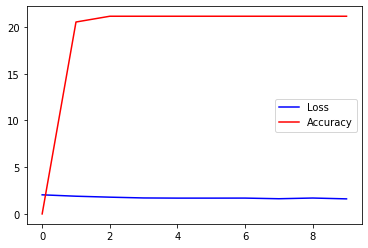

In [ ]:
pbar = tqdm(range(args.end_iter))
all_loss = np.zeros(args.end_iter,float)
all_accuracy = np.zeros(args.end_iter,float)

###########################
## Optimizer and Loss
###########################
optimizer = torch.optim.Adam(model1.parameters(), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()         ## Default was F.nll_loss
 
for iter_ in pbar:     ## Iterating over training iterations in each prune iteration
    ################################
    ## Frequency for Testing
    ################################
    accuracy = test(model1, new_test_loader, criterion)
    
    ###################
    ## Training
    ###################
    loss = train(model1, new_train_loader, optimizer, criterion)
    all_loss[iter_] = loss
    all_accuracy[iter_] = accuracy
    # print(f"\nTrain epoch: {iter_} | All_accuracy: {all_accuracy} |  accuracy at that epoch: {accuracy}")
    # print(f"\nTrain epoch: {iter_} | All_loss: {all_loss} | accuracy at that epoch: {loss}")

plt.plot(all_loss, color = 'blue', label = "Loss")
plt.plot(all_accuracy, color = 'red', label = "Accuracy")
plt.legend()

Text(0.5, 1.0, 'Plot of Accuracy and Loss vs. Pruning Iterations')

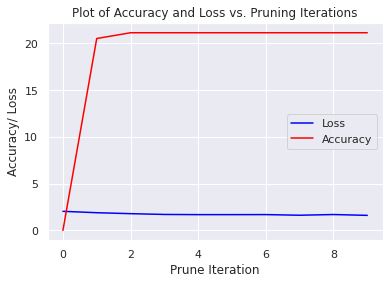

In [ ]:
import seaborn as sns
sns.set()
plt.plot(all_loss, color = 'blue', label = "Loss")
plt.plot(all_accuracy, color = 'red', label = "Accuracy")
plt.legend()
plt.xlabel("Prune Iteration")
plt.ylabel("Accuracy/ Loss")
plt.title("Plot of Accuracy and Loss vs. Pruning Iterations")